In [121]:
# toutes les importations nécessaires, restart le kernel apres avoir importé les bibliothèques
#%pip install ortools # -> si nécessaire, pour installer le module ortools, décommenter cette ligne
import random
import math
from tqdm import tqdm # type: ignore
import matplotlib.pyplot as plt
from ortools.sat.python import cp_model # type: ignore
import time
import numpy as np
from random import shuffle

In [122]:
def lire_fichier(fichier): # Fonction pour lire le fichier d'entrée
    with open(fichier, 'r') as f:
        liste_items = []
        data = False
        max_capacity = None
        for ligne in f:
            ligne = ligne.strip()
            if ligne.startswith('MAX_CAPACITY:'):
                max_capacity = int(ligne.split()[1])
            elif ligne.startswith('DATA [id profit weight]:'):
                data = True
                continue
            if data and ligne:
                liste_items.append([int(x) for x in ligne.split()])
    return max_capacity, liste_items

In [123]:
# résolution linéaire de knapsack
def solve_knapsack_cp_sat(max_capacity, liste_items):
    #max_capacity, liste_items = lire_fichier(fichier)
    n = len(liste_items)
    model = cp_model.CpModel()
    
    x = []
    for i in range(n): # on crée une variable binaire pour chaque item : x_i = 1 si l'item i est pris, 0 sinon
        x.append(model.NewBoolVar(f"x_{i}"))

    model.Add(
        sum(liste_items[i][2] * x[i] for i in range(n)) <= max_capacity # fonction contrainte : somme des poids des items sélectionnés <= max_capacity
    )

    model.Maximize(
        sum(liste_items[i][1] * x[i] for i in range(n)) # fonction objectif : somme des profits des items sélectionnés
    )

    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status in (cp_model.OPTIMAL, cp_model.FEASIBLE):
        return solver.ObjectiveValue()
        # poids_total = 0
        # items_selectionnes = []
        # for i in range(n):
        #     if solver.Value(x[i]) == 1:
        #         idx_item = liste_items[i][0]
        #         weight_item = liste_items[i][2]
        #         items_selectionnes.append(idx_item)
        #         poids_total += weight_item

        #print(f"Poids total = {poids_total}")
        #print(f"Items sélectionnés (IDs) = {items_selectionnes}")
    else:
        print("Aucune solution trouvée.")
        return None

In [124]:
# Recuit simulé

def calculer_poids_total(liste_items, solution): 
    return sum(liste_items[i][2] for i in range(len(liste_items)) if solution[i] == 1)

def calculer_profit_total(liste_items, solution):
    return (-sum(liste_items[i][1] for i in range(len(liste_items)) if solution[i] == 1))

def verifier_solution(liste_items, solution, max_capacity):
    return calculer_poids_total(liste_items, solution) <= max_capacity

def generer_solution_aleatoire(liste_items):
    return [random.randint(0, 1) for _ in range(len(liste_items))]

def generer_voisin(solution):
    index = random.randint(0, len(solution) - 1)
    solution[index] = 1 if solution[index] == 0 else 0
    return solution

def accepter_solution_moins_bonne(delta, temperature):
    if temperature == 0:
        return 1.0
    else:
        proba = math.exp(-delta / temperature)
        return random.random() < proba

def sort_items(liste_items):
    return sorted(liste_items, key=lambda x: x[1] / x[2], reverse=True)

from random import shuffle

def f_solution_initiale(liste_items, capacite_max, taux_utilisation=1.0):
    n = len(liste_items)
    solution = [0] * n
    indices = list(range(n))
    capacite_cible = capacite_max * taux_utilisation
    poids_total = 0

    shuffle(indices)

    for i in indices:
        poids = liste_items[i][1]  # poids = deuxième élément de l'item
        if poids_total + poids <= capacite_cible:
            solution[i] = 1
            poids_total += poids

    return solution


def recuit_simule(liste_items, capacite_max, temperature_initiale, n1, n2, mu, solution_initiale):
    solution = solution_initiale[:]
    meilleur_solution = solution_initiale[:]
    for i in range(n1):
        #temperature = temperature_initiale * (mu ** i)
        temperature = temperature_initiale * (1 - mu)
        for j in range(n2):
            voisin = generer_voisin(solution[:])
            if not verifier_solution(liste_items, voisin, capacite_max):
                continue
            delta = calculer_profit_total(liste_items, voisin) - calculer_profit_total(liste_items, solution)
            if delta < 0 or accepter_solution_moins_bonne(delta, temperature):
                solution = voisin
                if calculer_profit_total(liste_items, solution) < calculer_profit_total(liste_items, meilleur_solution):
                    meilleur_solution = solution[:]
    return meilleur_solution

In [125]:
# fonction de test et de stockage des résultats pour le recuit simulé   
def tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales, n1, n2, mus, num_runs):
    results = {}
    total_iterations = len(n1) * len(n2) * len(temperatures_initiales) * len(mus) * num_runs
    var = "n1" if len(n1) != 1 else \
      "n2" if len(n2) != 1 else \
      "temperature_initiale" if len(temperatures_initiales) != 1 else \
      "mu"
    with tqdm(total=total_iterations, desc=f"Variation de {var} ") as pbar:
        for n1_val in n1:
            for n2_val in n2: 
                for temperature_initiale in temperatures_initiales:
                    for mu in mus:              
                        profits = []
                        for _ in range(num_runs):
                            solution = recuit_simule(liste_items, capacite_max, temperature_initiale, n1_val, n2_val, mu, solution_initiale)
                            profit = -calculer_profit_total(liste_items, solution)
                            profits.append(profit)
                            pbar.update(1)
                        results[(n1_val, n2_val, temperature_initiale, mu)] = profits
    return results

In [126]:
def afficher_graphes_parametres(results, n1, n2, temperatures_initiales, mus, var, profit_max):
    profits_par_temp = {}
    profits_par_n1 = {}
    profits_par_n2 = {}
    profits_par_mu = {}

    for (n1_val, n2_val, temp, mu), profits in results.items():
        mean_profit = sum(profits) / len(profits)

        profits_par_n1.setdefault(n1_val, []).append(mean_profit)
        profits_par_n2.setdefault(n2_val, []).append(mean_profit)
        profits_par_temp.setdefault(temp, []).append(mean_profit)
        profits_par_mu.setdefault(mu, []).append(mean_profit)

    mean_profits_n1 = {n1_val: sum(profits) / len(profits) for n1_val, profits in profits_par_n1.items()}
    mean_profits_n2 = {n2_val: sum(profits) / len(profits) for n2_val, profits in profits_par_n2.items()}
    mean_profits_temp = {temp: sum(profits) / len(profits) for temp, profits in profits_par_temp.items()}
    mean_profits_mu = {mu: sum(profits) / len(profits) for mu, profits in profits_par_mu.items()}

    median_n1 = np.median(n1)
    median_n2 = np.median(n2)
    median_temp = np.median(temperatures_initiales)
    median_mu = np.median(mus)

    if var == 'temp':
        plt.figure()
        plt.plot(list(mean_profits_temp.keys()), list(mean_profits_temp.values()), marker='o')
        plt.axhline(y=profit_max, color='r', linestyle='--', label='Profit max')
        plt.title(f'Profit moyen en fonction de temperature_initiale, (n1={median_n1}, n2={median_n2}, mu={median_mu})')
        plt.xlabel('temperature_initiale')
        plt.ylabel('Profit moyen')
        plt.grid(True)
        plt.show()
    
    if var == 'n1':
        plt.figure()
        plt.plot(list(mean_profits_n1.keys()), list(mean_profits_n1.values()), marker='o')
        plt.axhline(y=profit_max, color='r', linestyle='--', label='Profit max')
        plt.title(f'Profit moyen en fonction de n1, (n2={median_n2}, temp={median_temp}, mu={median_mu})')
        plt.xlabel('n1 (max_iter)')
        plt.ylabel('Profit moyen')
        plt.grid(True)
        plt.show()
    
    if var == 'n2':
        plt.figure()
        plt.plot(list(mean_profits_n2.keys()), list(mean_profits_n2.values()), marker='o')
        plt.axhline(y=profit_max, color='r', linestyle='--', label='Profit max')
        plt.title(f'Profit moyen en fonction de n2, (n1={median_n1}, temp={median_temp}, mu={median_mu})')
        plt.xlabel('n2 (max_iter)')
        plt.ylabel('Profit moyen')
        plt.grid(True)
        plt.show()
        
    if var == 'mu':
        plt.figure()
        plt.plot(list(mean_profits_mu.keys()), list(mean_profits_mu.values()), marker='o')
        plt.axhline(y=profit_max, color='r', linestyle='--', label='Profit max')
        plt.title(f'Profit moyen en fonction de 1 - mu, (n1={median_n1}, n2={median_n2}, temp={median_temp})')
        plt.xlabel('mu')
        plt.ylabel('Profit moyen')
        plt.grid(True)
        plt.show()


--- Résultats pour pi-13-100-1000-001.kna ---
--------------------
Temps de résolution CP-SAT: 0.02 secondes
Profit max :  1989.0
--------------------
Liste triée :  [[1, 234, 114], [2, 39, 19], [6, 78, 38], [9, 312, 152], [10, 156, 76], [11, 156, 76], [12, 273, 133], [15, 312, 152], [17, 156, 76], [25, 39, 19], [32, 351, 171], [33, 351, 171], [34, 156, 76], [35, 351, 171], [36, 390, 190], [38, 156, 76], [39, 312, 152], [40, 390, 190], [43, 234, 114], [45, 195, 95], [50, 78, 38], [52, 234, 114], [54, 117, 57], [60, 156, 76], [61, 39, 19], [62, 351, 171], [65, 156, 76], [66, 390, 190], [67, 390, 190], [68, 78, 38], [71, 312, 152], [72, 156, 76], [73, 312, 152], [74, 39, 19], [76, 39, 19], [79, 234, 114], [83, 195, 95], [84, 351, 171], [85, 312, 152], [86, 273, 133], [88, 312, 152], [89, 390, 190], [91, 390, 190], [94, 390, 190], [96, 117, 57], [97, 78, 38], [99, 234, 114], [100, 273, 133], [103, 156, 76], [107, 312, 152], [108, 156, 76], [3, 1053, 873], [4, 351, 291], [5, 585, 485], [7

Variation de temperature_initiale : 100%|██████████| 800/800 [00:50<00:00, 15.94it/s]


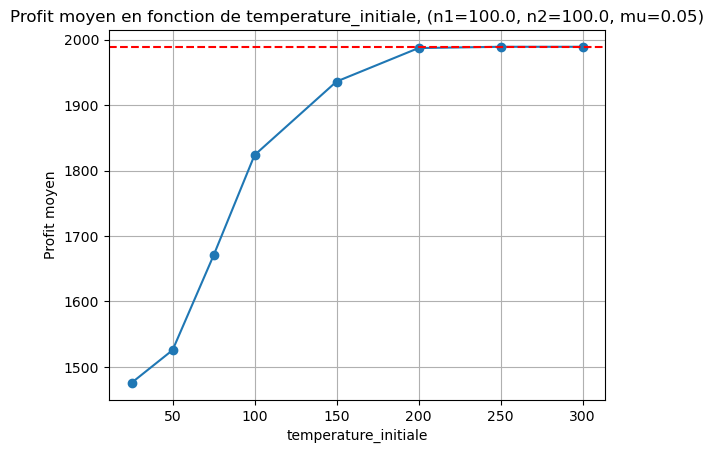

Variation de n1 : 100%|██████████| 700/700 [01:15<00:00,  9.25it/s] 


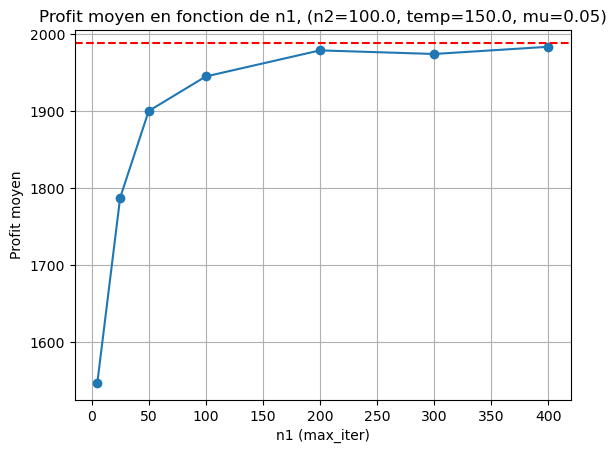

Variation de n2 : 100%|██████████| 700/700 [01:14<00:00,  9.43it/s] 


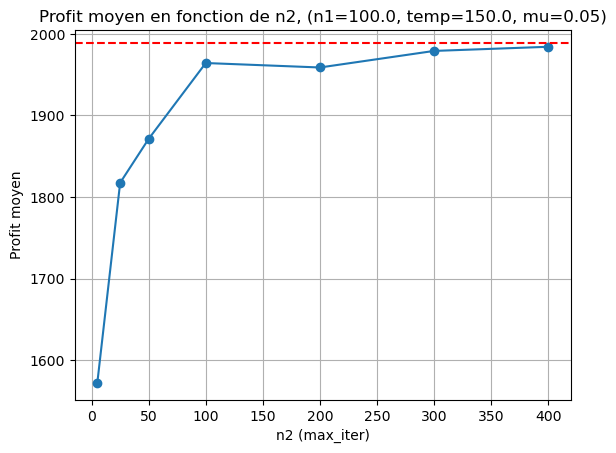

Temps de résolution Recuit Simulé : 200.35 secondes
--------------------


In [ ]:
fichiers = [
        #'pi-12-100-1000-001.kna',
        #'pi-12-1000-1000-001.kna',
        #'pi-12-10000-1000-001.kna',
        'pi-13-100-1000-001.kna',
        #'pi-13-1000-1000-001.kna',
        #'pi-13-10000-1000-001.kna',
        #'pi-15-100-1000-001.kna',
        #'pi-15-1000-1000-001.kna',
        #'pi-15-10000-1000-001.kna'
    ]

# Paramètres pour le recuit simulé
temperatures_initiales = [500, 5000, 10000]
n1 = [10, 50, 100, 250, 500, 750, 1000]
n2 = [10, 100, 1000]
mus = [0.01, 0.1, 0.25]


# Exemple d'utilisation
# fichier = 'pi-12-100-1000-001.kna'
# capacite_max, liste_items = lire_fichier(fichier)
# print("Capacité max = ", capacite_max)
# solution_initiale = f_solution_initiale(liste_items, capacite_max)
# print("Solution initiale : ", solution_initiale)
# temperature_initiale = 1000
# n1 = 100
# n2 = 1000
# mu = 0.1
# print("Paramètres : n1 = ", n1, ", n2 = ", n2, ", mu = ", mu)
# result = recuit_simule(liste_items, capacite_max, temperature_initiale, n1, n2, mu, solution_initiale)
# print("Profit total : ", -calculer_profit_total(liste_items, result))

temperatures_initiales = [25,50,75, 100, 150, 200,250,300]
n1 = [5,25, 50, 100, 200, 300, 400]
n2 = [5,25, 50, 100, 200, 300, 400]
mus = [0.05]

temperatures_initiales_default = [150]
n1_default = [100]
n2_default = [100]
mus_default = [0.05]

# temperatures_initiales = [10, 25, 50, 100, 250, 500, 1000]
# n1 = [10, 25, 50, 100, 200, 500, 1000]
# n2 = [10, 25, 50, 100, 200, 500, 1000]
# mus = [0.05]


# temperatures_initiales_default = [250]
# n1_default = [100]
# n2_default = [100]
# mus_default = [0.05]

# on va plutot tester 1 paramètre à la fois, pour voir l'impact de chaque paramètre
# les autres paramètres seront fixés à une valeur par défaut
# n1 = 100, n2 = 1000, temperature_initiale = 1000, mu = 0.1


for fichier in fichiers:
    print(f"\n--- Résultats pour {fichier} ---")
    print("-" * 20)
    capacite_max, liste_items = lire_fichier(fichier)
    #print("Capacité max = ", capacite_max)
    start_time = time.time()
    profit_max = solve_knapsack_cp_sat(capacite_max, liste_items)
    end_time = time.time()
    print(f"Temps de résolution CP-SAT: {end_time - start_time:.2f} secondes")
    print("Profit max : ", profit_max)
    print("-" * 20)
    
    liste_items = sort_items(liste_items)
    print("Liste triée : ", liste_items)
    solution_initiale = f_solution_initiale(liste_items, capacite_max, taux_utilisation=0.5)
    print("Solution initiale : ", solution_initiale)
    profit_initial = calculer_profit_total(liste_items, solution_initiale)
    poids_initial = calculer_poids_total(liste_items, solution_initiale)
    print("Profit initial : ", -profit_initial)
    #print("Solution initiale : ", solution_initiale)
    # results = tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales, n1, n2, mus, 10)
    # variation de la température initiale
    start_time = time.time()
    results_temp = tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales, n1_default, n2_default, mus_default, 100)
    afficher_graphes_parametres(results_temp, n1_default, n2_default, temperatures_initiales, mus_default, "temp", profit_max)
    results_n1 = tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales_default, n1, n2_default, mus_default, 100)   
    afficher_graphes_parametres(results_n1, n1, n2_default, temperatures_initiales_default, mus_default, "n1", profit_max)
    results_n2 = tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales_default, n1_default, n2, mus_default, 100)   
    afficher_graphes_parametres(results_n2, n1_default, n2, temperatures_initiales_default, mus_default, "n2", profit_max)
    # results_mu = tester_recuit_simule(liste_items, capacite_max, solution_initiale, temperatures_initiales_default, n1_default, n2_default, mus, 100)
    # afficher_graphes_parametres(results_mu, n1_default, n2_default, temperatures_initiales_default, mus, "mu", profit_max)
    end_time = time.time()
    print(f"Temps de résolution Recuit Simulé : {end_time - start_time:.2f} secondes")
    print("-" * 20)
    #afficher_graphes_parametres(results, temperatures_initiales, n1, n2, mus)
